<a href="https://colab.research.google.com/github/pythonjjj/AtividadesDIO/blob/main/CatvDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# versão atual: kagglecatsanddogs_5340.zip. Para atualizações visite https://www.microsoft.com/en-us/download/details.aspx?id=54765

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2024-12-02 21:12:29--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.38.253.179, 2600:1407:7400:1187::317f, 2600:1407:7400:1184::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.38.253.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  33.0MB/s    in 9.8s    

2024-12-02 21:12:39 (80.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
#teste para saber o tamanho das listas

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# saídas esperadas:
# 12501
# 12501

12501
12501


In [4]:
#criando os diretórios no Linux do COLAB
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass


In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# saídas esperadas
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
# testes

print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Saídas esperadas:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [10]:
#teste que ajudou a arrumar o problema de compilação no bloco seguinte. lr => learning_rate
print(tf.__version__)

2.17.1


In [11]:
# Chamando o modelo que será usado

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [13]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Saída esperada:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [14]:
#Treinamento
# Nota: isso pode levar um tempo... (aproximadamente 1h)
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/90 ━━━━━━━━━━━━━━━━━━━━ 1:36 7s/step - acc: 0.5322 - loss: 0.7450

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 653s 7s/step - acc: 0.5374 - loss: 0.7361 - val_acc: 0.5873 - val_loss: 0.6634
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6070 - val_loss: 0.6432
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 677s 7s/step - acc: 0.6594 - loss: 0.6163 - val_acc: 0.6027 - val_loss: 0.6583
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5960 - val_loss: 0.6584
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - acc: 0.7039 - loss: 0.5656 - val_acc: 0.6647 - val_loss: 0.5994
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6870 - val_loss: 0.5748
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 662s 7s/step - acc: 0.7355 - loss: 0.5295 - val_acc: 0.7347 - val_loss: 0.4989
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7540 - val_loss: 0.4987
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 628s 7s/step - acc: 0.7547 - loss: 0.4963 - val_acc: 0.7627 - val_loss: 0.4696
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

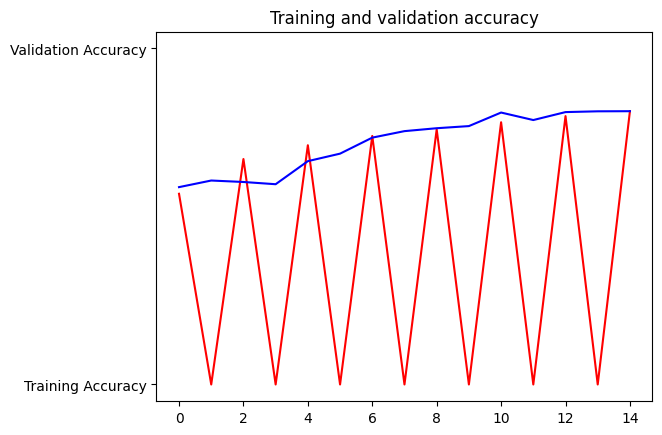

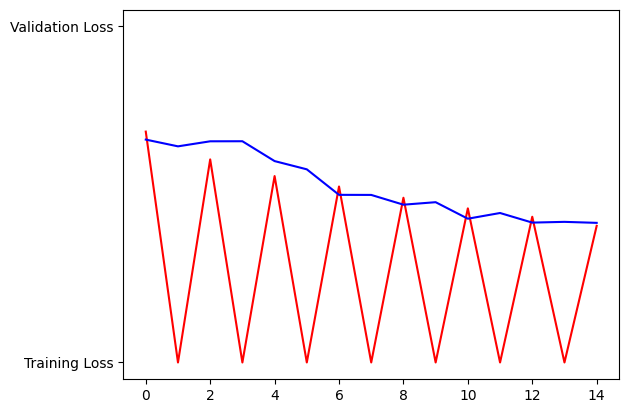

<Figure size 640x480 with 0 Axes>

In [17]:
# Gráficos demonstrativos

%matplotlib inline
# mostra os gráficos dentro do notebook

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#---------------------------------------------------------
# Devolve uma lista de resultados dos dados de treinamento e teste
# conjuntos para cada época de treinamento
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # devolve o número de épocas

#------------------------------------------------
# Plota treinamento e precisão de validação por época
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plota as perdas durante treinamento e validação por época
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

# Saídas desejadas: gráficos com as métricas dos treinamentos e valizações.



In [18]:
# Faça o uploado de uma imagem para classificação (Cães ou gatos)

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predições
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " É um cachorro ")
  else:
    print(fn + " É um gato ")

Saving gato.jpg to gato.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
[0.]
gato.jpg is a cat


Saving gato.jpg to gato (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


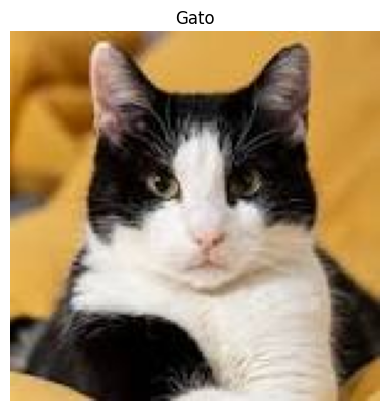

gato (1).jpg: É um gato


In [19]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Fazer upload das imagens
uploaded = files.upload()

for fn in uploaded.keys():
    # Caminho da imagem
    path = '/content/' + fn

    # Carregar a imagem e redimensionar
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Adicionar dimensão para batch

    # Fazer a predição
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # Mostrar a imagem
    plt.imshow(img)  # Exibir a imagem
    plt.axis('off')  # Remover os eixos para estética
    plt.title("Cachorro" if classes[0] > 0.5 else "Gato")  # Título baseado na predição
    plt.show()  # Renderizar o gráfico

    # Mostrar o resultado no console
    if classes[0] > 0.5:
        print(f"{fn}: É um cachorro")
    else:
        print(f"{fn}: É um gato")


Referências:

https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br

https://academiapme-my.sharepoint.com/:w:/g/personal/kawan_dio_me/EQe4Pxlc2AxJlgnzavGVT8YBmVqrUCPPfeYZ4XFpybYtOA?rtime=z3p30xQT3Ug

https://www.microsoft.com/en-us/download/details.aspx?id=54765

https://github.com/lmoroney/mlday-tokyo/blob/master/Lab6-Cats-v-Dogs.ipynb

https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb